# This is Cartography put together into one place. 

# Modules to Add to run this code:

- [BioPython][1]
- [Pandas][2]
- [Numpy][3]
- [Altair][4]
- [Seaborn][5]
- [Scikit-Learn][6]
- [UMAP][7]
[1]:https://biopython.org/wiki/Download
[2]:https://pandas.pydata.org/pandas-docs/version/0.23.3/install.html
[3]:https://docs.scipy.org/doc/numpy/user/quickstart.html
[4]:https://altair-viz.github.io/getting_started/installation.html
[5]:https://seaborn.pydata.org/installing.html
[6]:
[7]:


# METHODS SECTION
- All the methods I use throughout this notebook is all together up here. 

### Taking the result strains from reading in the metadata and concatenating it to the principal components (where each row is joined with one genome)

In [1]:
"""
principal_Df -- Data from data reduction (-T-SNE, MDS, etc) (pandas DataFrame)
result_metadata -- the metadata that is being read in (Pandas DataFrame)
fields, the parts of metadata that should be concatenated with princiapl_Df (list)
"""
def concatenate_results_with_strain_data(principal_Df,result_metadata,fields):
    finalDf = pd.concat([principal_Df, result_metadata[fields]], axis = 1)
    return finalDf

### Altair method for easy tooltip/brushing below

In [2]:
"""
Defining Fields:
finalDf: The data that is used to generate the scatter plot (pandas DataFrame)
x, the data you want on the x axis (string)
y, the data you want on the y axis (string)
Titlex,the name you want on the x axis (string)
Titley, the name you want on the y axis (string)
Tooltip, when scanning over a point, the data you want avaiable (list)
Color, what the scatterplot is colored by (String)
"""
def scatterplot_with_tooltip_interactive(finalDf,x,y,Titlex,Titley,ToolTip,color):
    import altair as alt
    brush = alt.selection(type='interval', resolve='global')
    chart = alt.Chart(finalDf).mark_circle(size=60).encode(
        x=alt.X(x,title=Titlex),
        y=alt.X(y,title=Titley),
        color=color,
        tooltip=ToolTip
    ).interactive()
    chart.display()
    #return chart

### Linking tree with plots brush

In [3]:
"""
dataframe: dataframe including node data and dimensionality reduction data (Pandas Dataframe)
list_of_data: list of all the names of the columns in the dataframe for which you want graphs: goes in the order of [x1,y1,x2,y2,x3,y3] etc.(list)
list_of_titles: list of all the TITLES you want for each axis: goes in order of[x1,y1,x2,y2,x3,y3] etc.(list)
color: what the data should be colored by (string)
ToolTip: when hovering over the data, what data should be shown (list)
"""
def linking_tree_with_plots_brush(dataFrame,list_of_data,list_of_titles,color,ToolTip):
    list_of_chart = []
    if(len(list_of_data) % 2 != 0 or len(list_of_titles) % 2 != 0):
        raise Exception('The length of list_of_data and the length of list_of_titles should not be odd.')
    else:
        import altair as alt
        base = alt.Chart(dataFrame)
        brush = alt.selection(type='interval', resolve='global')
        tree_name = base.mark_circle().encode(
            x=alt.X(
                "date:Q",
                scale=alt.Scale(domain=(node_df["date"].min() - 0.2, node_df["date"].max() + 0.2)),
                title="Date"
            ),
            y=alt.Y(
                "y:Q",
                title=""
            ),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
        ).add_selection(brush).properties(width=400,height=250)
        list_of_chart.append(tree_name)
        
        for i in range(0,len(list_of_data) - 1,2):
            if(i == len(list_of_data)):
                break
            chart = base.mark_circle(size=60).encode(
            x=alt.X(list_of_data[i],title=list_of_titles[i]),
            y=alt.X(list_of_data[i + 1],title=list_of_titles[i + 1]),
            color=alt.condition(brush, color, alt.ColorValue('gray')),
            tooltip=ToolTip
            ).add_selection(
                brush
            ).properties(
                width=250,
                height=250
            )
            list_of_chart.append(chart)
        return list_of_chart

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- I opened and imported the json from a build from NextStrain ([flu][2], [zika][3], etc)
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html
[2]: https://github.com/nextstrain/seasonal-flu
[3]: https://altair-viz.github.io/index.html

In [4]:
import altair as alt
from augur.utils import json_to_tree
import json
import pandas as pd

In [5]:
# Import modules
with open('Data/zika_tree.json') as fh:
    json_tree_handle = json.load(fh)
#json_tree_handle = json.loads(requests.get("http://data.nextstrain.org/zika_tree.json").text)
# Download tree JSON file used by auspice. Despite its filename extension, the data are compressed.
#http = urllib3.PoolManager()
# = http.request('GET', "")


In [6]:
tree = json_to_tree(json_tree_handle)

In [7]:
tree

Clade(branch_length=0, clade=940, name='NODE_0000520', numdate=2007.1438944876675, strain='NODE_0000520', yvalue=510.91459311393555)

In [8]:
node_data = [
    {
        "strain": node.name,
        "date": node.attr["num_date"],
        "y": node.yvalue,
        "region": node.attr["region"],
        "country": node.attr["country"],
        "parent_date": node.parent is not None and node.parent.attr["num_date"] or node.attr["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue
    }
    for node in tree.find_clades(terminal=True)
]

In [9]:
node_data[10]

{'strain': 'V20366',
 'date': 2018.7748117727583,
 'y': 507,
 'region': 'south_asia',
 'country': 'india',
 'parent_date': 2018.510007605652,
 'parent_y': 507.5}

In [10]:
node_df = pd.DataFrame(node_data)

In [11]:
node_df.head()

country         date  parent_date  parent_y          region  \
0  thailand  2013.136893  2010.921473    516.50  southeast_asia   
1  thailand  2016.665298  2010.921473    516.50  southeast_asia   
2  thailand  2015.043806  2010.006479    514.25  southeast_asia   
3  thailand  2016.919918  2011.367398    513.50  southeast_asia   
4  thailand  2013.722793  2011.367398    513.50  southeast_asia   

              strain    y  
0  THA/PLCal_ZV/2013  517  
1           SI_BKK01  516  
2          SV0010/15  515  
3       DMSc05684_16  514  
4         SK403/13AS  513

In [12]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [13]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [14]:
node_df.shape

(517, 7)

In [15]:
node_df.head()

country         date  parent_date  parent_y          region  \
0  thailand  2013.136893  2010.921473      0.00  southeast_asia   
1  thailand  2016.665298  2010.921473      0.00  southeast_asia   
2  thailand  2015.043806  2010.006479      2.25  southeast_asia   
3  thailand  2016.919918  2011.367398      3.00  southeast_asia   
4  thailand  2013.722793  2011.367398      3.00  southeast_asia   

              strain  y  
0  THA/PLCal_ZV/2013  0  
1           SI_BKK01  1  
2          SV0010/15  2  
3       DMSc05684_16  3  
4         SK403/13AS  4

In [16]:
node_df["region"].unique()

array(['southeast_asia', 'south_asia', 'oceania', 'china',
       'north_america', 'south_america', 'japan_korea'], dtype=object)

### Reading in the Fasta File
- I used BioPython to parse the Fasta file into two numpy Arrays: Genomes and Strains. 

In [17]:
#work on making this work

import pandas as pd
import numpy as np
from Bio import SeqIO
strains = []
genomes = []
for record in SeqIO.parse('Data/zika_aligned.fasta', "fasta"):
    strains.append(str(record.id))
    genomes.append(str(record.seq))

#### Checking to make sure the file I picked is a aligned Fasta file / is the file I wanted

In [18]:
len(strains)
print(len(genomes[0]) == len(genomes[1]))
print(len(genomes))

True
519


In [19]:
strains[:5]

['DOM/2016/MA_WGS16_024',
 'DOM/2016/BB_0180',
 'DOM/2016/BB_0115',
 'DOM/2016/BB_0208',
 'DOM/2016/MA_WGS16_007']

# Creating the Distance Matrix
- I used Hamming Distance to find the pairwise distance between each genome and each other genome, effectively creating a similarity/distance matrix
    - In my Hamming Distance method, I only counted something as a different if it was a mismatch between the nucleotides (A,G,C, or T), not gaps (as that was throwing off the algorithm too much for smaller strains)
- I then used Seaborn to generate a heatmap to make sure the matrix looked correct

In [9]:
# Return the Hamming distance between string1 and string2.
# string1 and string2 should be the same length.
def hamming_distance(array1, array2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(array1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if array1[i] != array2[i] and array1[i] != 'N' and array2[i] != 'N':
            distance += 1
    # Return the final count of differences
    return distance

In [10]:
#Using the Hamming distance to create a similarity matrix
numbers = []
matrixOfNum = []
for i in range(0, len(genomes)):
    for j in range(0,len(genomes)):
        num = hamming_distance(genomes[i],genomes[j])
        numbers.append(num)
    matrixOfNum.append(numbers)
    numbers = []
similarity_matrix = pd.DataFrame(matrixOfNum, columns = ["strain " + str(i) for i in range(1,len(matrixOfNum) + 1)], dtype="float")
print(similarity_matrix.head())

KeyboardInterrupt: 

AxesSubplot(0.125,0.125;0.62x0.755)


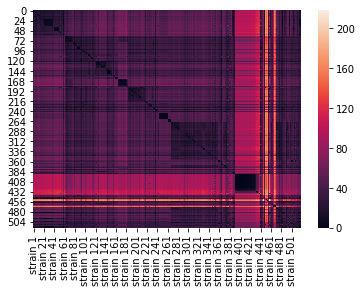

In [61]:
import seaborn as sns
print(sns.heatmap(similarity_matrix))

##### I read it out to a csv file to cut processing time for each run-through

In [11]:
similarity_matrix = similarity_matrix.to_csv("DistanceMatrix",sep=',',index=False)

NameError: name 'similarity_matrix' is not defined

## Note:
- After running it once, You don't need to run the distance matrix code again : Just read it in like below.

In [20]:
similarity_matrix = pd.read_csv("DistanceMatrix")

In [21]:
import seaborn as sns
print(sns.heatmap(similarity_matrix))

AxesSubplot(0.125,0.11;0.62x0.77)


# Reading in the Metadata
- The metadata is used for getting the region, country, etc of different strains. This data is used to color the clusters.
- The metadata contains all of the possible sampled strains, so many of these will not be in the genomes from the aligned file, probably because the strains were corrupted, too short, etc. 
- We merge this metadata with the strains we have in the aligned file to get a list of all of the strains that match between both. It should come out to the amount of strains in the aligned file.

In [22]:
#merging my final dataframe with their regions and strain names
metadata_df = pd.read_csv(r'Data/zika_metadata.tsv', delimiter='\t')

In [23]:
metadata_df.head()

strain virus accession        date   region           country  \
0  1_0015_PF  zika  KX447511  2014-01-XX  oceania  french_polynesia   
1  1_0016_PF  zika  KX447520  2014-01-XX  oceania  french_polynesia   
2  1_0030_PF  zika  KX447515  2013-11-XX  oceania  french_polynesia   
3  1_0035_PF  zika  KX447514  2014-01-XX  oceania  french_polynesia   
4  1_0038_PF  zika  KX447517  2014-01-XX  oceania  french_polynesia   

           division              city       db segment           authors  \
0  french_polynesia  french_polynesia  genbank  genome  Pettersson et al   
1  french_polynesia  french_polynesia  genbank  genome  Pettersson et al   
2  french_polynesia  french_polynesia  genbank  genome  Pettersson et al   
3  french_polynesia  french_polynesia  genbank  genome  Pettersson et al   
4  french_polynesia  french_polynesia  genbank  genome  Pettersson et al   

                                             url  \
0  https://www.ncbi.nlm.nih.gov/nuccore/KX447511   
1  https://www.ncbi.nlm.nih.gov/nuccore/KX447520   
2  https://www.ncbi.nlm.nih.gov/nuccore/KX447515   
3  https://www.ncbi.nlm.nih.gov/nuccore/KX447514   
4  https://www.ncbi.nlm.nih.gov/nuccore/KX447517   

                                               title  \
0  How Did Zika Virus Emerge in the Pacific Islan...   
1  How Did Zika Virus Emerge in the Pacific Islan...   
2  How Did Zika Virus Emerge in the Pacific Islan...   
3  How Did Zika Virus Emerge in the Pacific Islan...   
4  How Did Zika Virus Emerge in the Pacific Islan...   

                        journal                                     paper_url  
0  MBio 7 (5), e01239-16 (2016)  https://www.ncbi.nlm.nih.gov/pubmed/27729507  
1  MBio 7 (5), e01239-16 (2016)  https://www.ncbi.nlm.nih.gov/pubmed/27729507  
2  MBio 7 (5), e01239-16 (2016)  https://www.ncbi.nlm.nih.gov/pubmed/27729507  
3  MBio 7 (5), e01239-16 (2016)  https://www.ncbi.nlm.nih.gov/pubmed/27729507  
4  MBio 7 (5), e01239-16 (2016)  https://www.ncbi.nlm.nih.gov/pubmed/27729507

In [24]:
metadata_df.shape

(745, 15)

In [25]:
#making a dataframe out of the strains from the alignment file to merge with the metadata
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']

In [26]:
strains_df.shape

(519, 1)

In [27]:
#Merging strains and metadata 
result_strains = pd.merge(strains_df,metadata_df, on='strain')

In [28]:
#checking that no strains were lost
result_strains.shape

(519, 15)

In [29]:
np.setdiff1d(strains_df['strain'].unique(),metadata_df['strain'].unique())

array([], dtype=object)

# Running PCA on the Dataset
- I treated each nucleotide asa "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site.              
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

# Step 1: Creating a matrix of numbers with columns being sites and rows being strains 

In [30]:
i = 0
for i in range(0,len(genomes)):
    genomes[i] = list(genomes[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4').replace('N','5')
               .replace('R','5').replace('S','5').replace('M', '5').replace('Y', '5').replace('W','5')
               .replace('K','5').replace('B','5').replace('D','5'))
    genomes[i] = [float(j) for j in genomes[i]]
genomes_df = pd.DataFrame(genomes)
genomes_df.columns = ["Site " + str(k) for k in range(0,len(genomes[i]))]

In [31]:
genomes_df.head()

Site 0  Site 1  Site 2  Site 3  Site 4  Site 5  Site 6  Site 7  Site 8  \
0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   
1     2.0     1.0     1.0     4.0     3.0     1.0     2.0     1.0     3.0   
2     2.0     1.0     1.0     4.0     3.0     1.0     2.0     1.0     3.0   
3     5.0     5.0     1.0     4.0     3.0     1.0     2.0     1.0     3.0   
4     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0     5.0   

   Site 9  ...  Site 10759  Site 10760  Site 10761  Site 10762  Site 10763  \
0     5.0  ...         5.0         5.0         5.0         5.0         5.0   
1     4.0  ...         3.0         2.0         2.0         3.0         2.0   
2     4.0  ...         3.0         2.0         2.0         3.0         2.0   
3     4.0  ...         5.0         5.0         5.0         5.0         5.0   
4     5.0  ...         5.0         5.0         5.0         5.0         5.0   

   Site 10764  Site 10765  Site 10766  Site 10767  Site 10768  
0         5.0         5.0         5.0         5.0         5.0  
1         2.0         3.0         3.0         2.0         2.0  
2         2.0         3.0         3.0         2.0         2.0  
3         5.0         5.0         5.0         5.0         5.0  
4         5.0         5.0         5.0         5.0         5.0  

[5 rows x 10769 columns]

## Step 2: Find the mean of each column using np.mean() and subtract this from each number in the column (x - Mu)

In [32]:
genomes_numpy = np.array(genomes)
genomes_numpy1 = np.array(genomes)

In [33]:
genomes_numpy

array([[5., 5., 5., ..., 5., 5., 5.],
       [2., 1., 1., ..., 3., 2., 2.],
       [2., 1., 1., ..., 3., 2., 2.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [34]:
mean_numpy = np.mean(genomes_numpy, axis=0,dtype=np.float64)
mean_numpy

array([3.92870906, 3.49903661, 3.50289017, ..., 4.63776493, 4.45086705,
       4.47976879])

In [35]:
len(genomes[0])
mean_numpy.shape

(10769,)

In [36]:
i = 0
for i in range(0,len(genomes[i])):
    for j in range(0,len(genomes)):
        genomes_numpy[j,i] = genomes_numpy[j,i] - mean_numpy[i]


In [37]:
genomes_df = pd.DataFrame(genomes_numpy)

In [38]:
genomes_df.head()

0         1        2         3         4         5         6      \
0  1.071291  1.500963  1.49711  0.414258  0.836224  1.676301  1.262042   
1 -1.928709 -2.499037 -2.50289 -0.585742 -1.163776 -2.323699 -1.737958   
2 -1.928709 -2.499037 -2.50289 -0.585742 -1.163776 -2.323699 -1.737958   
3  1.071291  1.500963 -2.50289 -0.585742 -1.163776 -2.323699 -1.737958   
4  1.071291  1.500963  1.49711  0.414258  0.836224  1.676301  1.262042   

      7         8         9      ...    10759     10760     10761     10762  \
0  1.737958  0.884393  0.450867  ...  0.44316  0.653179  0.624277  0.404624   
1 -2.262042 -1.115607 -0.549133  ... -1.55684 -2.346821 -2.375723 -1.595376   
2 -2.262042 -1.115607 -0.549133  ... -1.55684 -2.346821 -2.375723 -1.595376   
3 -2.262042 -1.115607 -0.549133  ...  0.44316  0.653179  0.624277  0.404624   
4  1.737958  0.884393  0.450867  ...  0.44316  0.653179  0.624277  0.404624   

      10763     10764     10765     10766     10767     10768  
0  0.595376  0.578035  0.373796  0.362235  0.549133  0.520231  
1 -2.404624 -2.421965 -1.626204 -1.637765 -2.450867 -2.479769  
2 -2.404624 -2.421965 -1.626204 -1.637765 -2.450867 -2.479769  
3  0.595376  0.578035  0.373796  0.362235  0.549133  0.520231  
4  0.595376  0.578035  0.373796  0.362235  0.549133  0.520231  

[5 rows x 10769 columns]

In [139]:
from sklearn.decomposition import PCA

#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(genomes_df)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component " + str(i) for i in range(1,11)])

In [140]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

principal components  explained variance
0                     1              0.1234
1                     2              0.0283
2                     3              0.0258
3                     4              0.0231
4                     5              0.0213
5                     6              0.0186
6                     7              0.0178
7                     8              0.0152
8                     9              0.0140
9                    10              0.0135

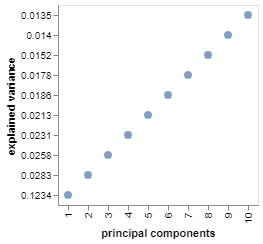

In [141]:
import altair as alt 

alt.Chart(df).mark_circle(size=60).encode(
    x='principal components:N',
    y='explained variance:N')

In [40]:
principalDf.head()

principal component 1  principal component 2  principal component 3  \
0             -18.701136              -2.695925              -4.643543   
1             -27.954344              13.316649               4.709408   
2             -27.967235              13.318665               4.733974   
3             -27.314532              12.392770               4.194193   
4               0.376124             -27.418253             -19.793464   

   principal component 4  principal component 5  principal component 6  \
0               0.732908              -1.023498               4.946784   
1               1.347644               1.842175              -6.703103   
2               1.353565               1.781710              -6.682366   
3               1.200291               1.420500              -5.328784   
4              10.785468              -6.151841               9.539998   

   principal component 7  principal component 8  principal component 9  \
0               0.466124              -4.214987              -4.574138   
1               2.452967               4.575572               1.766834   
2               2.431725               4.545631               1.737506   
3               1.881091               3.473560               1.321899   
4               0.651334               1.647239              -4.167116   

   principal component 10  
0               -6.908700  
1                4.218038  
2                4.201932  
3                3.136685  
4               -5.726275

# Merging Strain and PCA

In [41]:
strains_df = pd.DataFrame(strains)
strains_df.columns = ['strain']

In [42]:
result_strains = pd.merge(strains_df,metadata_df, on='strain')

In [43]:
finalDf = pd.concat([principalDf, result_strains[['region','country','strain']]], axis = 1)

In [44]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [45]:
merged_df.head()

principal component 1  principal component 2  principal component 3  \
0             -18.701136              -2.695925              -4.643543   
1             -27.954344              13.316649               4.709408   
2             -27.967235              13.318665               4.733974   
3             -27.314532              12.392770               4.194193   
4               0.376124             -27.418253             -19.793464   

   principal component 4  principal component 5  principal component 6  \
0               0.732908              -1.023498               4.946784   
1               1.347644               1.842175              -6.703103   
2               1.353565               1.781710              -6.682366   
3               1.200291               1.420500              -5.328784   
4              10.785468              -6.151841               9.539998   

   principal component 7  principal component 8  principal component 9  \
0               0.466124              -4.214987              -4.574138   
1               2.452967               4.575572               1.766834   
2               2.431725               4.545631               1.737506   
3               1.881091               3.473560               1.321899   
4               0.651334               1.647239              -4.167116   

   principal component 10         region           country_x  \
0               -6.908700  north_america  dominican_republic   
1                4.218038  north_america  dominican_republic   
2                4.201932  north_america  dominican_republic   
3                3.136685  north_america  dominican_republic   
4               -5.726275  north_america  dominican_republic   

                  strain           country_y         date  parent_date  \
0  DOM/2016/MA_WGS16_024  dominican_republic  2016.517454  2016.177960   
1       DOM/2016/BB_0180  dominican_republic  2016.298426  2015.782991   
2       DOM/2016/BB_0115  dominican_republic  2016.279261  2015.738263   
3       DOM/2016/BB_0208  dominican_republic  2016.303901  2016.145963   
4  DOM/2016/MA_WGS16_007  dominican_republic  2016.358658  2016.145963   

   parent_y    y  
0     202.0  202  
1     188.0  188  
2     171.5  172  
3     205.0  205  
4     205.0  206

In [46]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

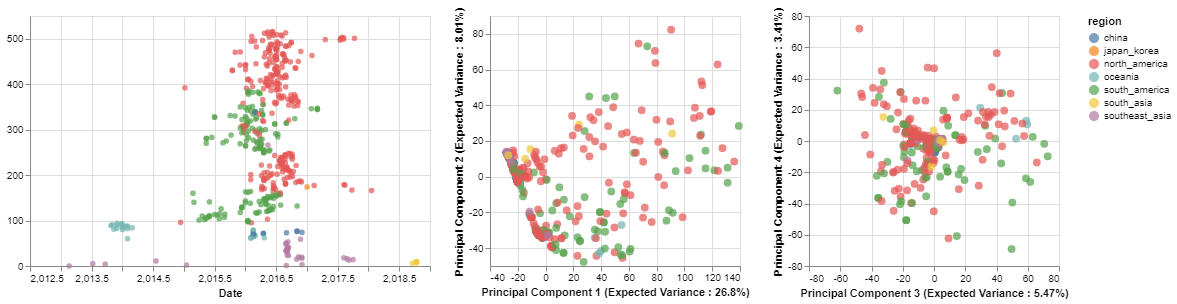

In [47]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['principal component 1','principal component 2','principal component 3','principal component 4'],
                                         ['Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                          'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                          'Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                          'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                                         "region:N",['strain','region'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]


## Step Three: Find the frequency of each letter and divide each number in each column by that number

In [48]:
def scale_column(column):
    count_A = len((np.where(column < 1.1))[0])
    count_G = len((np.where((column < 2.1) & (column > 1.1))[0]))
    count_C = len((np.where((column < 3.1) & (column > 2.1))[0]))
    count_T = len((np.where((column < 4.1) & (column > 3.1))[0]))
    count_N = len((np.where((column < 5.1) & (column > 4.1))[0]))
    return [count_A/float(len(column)), count_G/float(len(column)), count_C/float(len(column)), count_T/float(len(column)), count_N/float(len(column))]

In [49]:
import math
def return_column(genome_org, genome_column,counts):
    for i in range(0,len(genome_column)):
        if(genome_org[i] == 1.0):
            genome_column[i] = genome_column[i] / math.sqrt(float(math.fabs(counts[0])) * (1 - float(math.fabs(counts[0])))) 
        if(genome_org[i] == 2.0):
            genome_column[i] = genome_column[i] / math.sqrt(float(math.fabs(counts[1])) * (1 - float(math.fabs(counts[1])))) 
        if(genome_org[i] == 3.0):
            genome_column[i] = genome_column[i] / math.sqrt(float(math.fabs(counts[2])) * (1 - float(math.fabs(counts[2])))) 
        if(genome_org[i] == 4.0):
            genome_column[i] = genome_column[i] / math.sqrt(float(math.fabs(counts[3])) * (1 - float(math.fabs(counts[3]))))  
        if(genome_org[i] == 5.0):
            genome_column[i] = genome_column[i] / math.sqrt(float(math.fabs(counts[4])) * (1 - float(math.fabs(counts[4])))) 
    return genome_column

In [50]:
genomes_numpy

array([[ 1.07129094,  1.50096339,  1.49710983, ...,  0.36223507,
         0.54913295,  0.52023121],
       [-1.92870906, -2.49903661, -2.50289017, ..., -1.63776493,
        -2.45086705, -2.47976879],
       [-1.92870906, -2.49903661, -2.50289017, ..., -1.63776493,
        -2.45086705, -2.47976879],
       ...,
       [ 1.07129094,  1.50096339,  1.49710983, ...,  0.36223507,
         0.54913295,  0.52023121],
       [ 1.07129094,  1.50096339,  1.49710983, ...,  0.36223507,
         0.54913295,  0.52023121],
       [ 1.07129094,  1.50096339,  1.49710983, ...,  0.36223507,
         0.54913295,  0.52023121]])

In [115]:
q = 0
for q in range(0,len(genomes[q])):
    counts = scale_column(genomes_numpy1[:,q])
    genomes_numpy[:,q] = return_column(genomes_numpy1[:,q],genomes_numpy[:,q],counts)

In [116]:
df = pd.DataFrame(genomes_numpy)

In [117]:
from sklearn.decomposition import PCA

#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component " + str(i) for i in range(1,11)])

In [126]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

principal components  explained variance
0                     1              0.1234
1                     2              0.0283
2                     3              0.0258
3                     4              0.0231
4                     5              0.0213
5                     6              0.0186
6                     7              0.0178
7                     8              0.0152
8                     9              0.0140
9                    10              0.0135

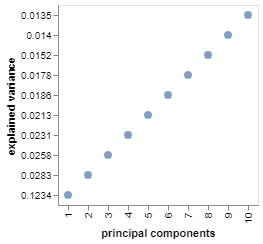

In [127]:
import altair as alt 

alt.Chart(df).mark_circle(size=60).encode(
    x='principal components:N',
    y='explained variance:N')

In [54]:
principalDf.head()

principal component 1  principal component 2  principal component 3  \
0             -71.062208              10.301595              -6.094765   
1             -81.086360              22.498641               6.060886   
2             -81.214990              22.731260               6.707962   
3             -79.540710              22.295288               5.011037   
4             -40.493432               0.525493             -42.564740   

   principal component 4  principal component 5  principal component 6  \
0              -1.956064               5.286970               1.215671   
1               9.786373               0.268714             -11.657046   
2              11.306462              -0.621210             -12.798462   
3              10.244133              -0.701505             -11.084964   
4              -6.391182              -0.057135              20.335041   

   principal component 7  principal component 8  principal component 9  \
0               4.289157               1.491331              -3.654120   
1              14.133656              -9.754941             -11.976997   
2              13.926060              -9.820343             -11.435373   
3              12.207707              -8.136109              -9.901459   
4             -11.305920              27.302156              26.184438   

   principal component 10  
0                1.137873  
1               -9.643675  
2               -8.012753  
3               -8.078433  
4               33.601364

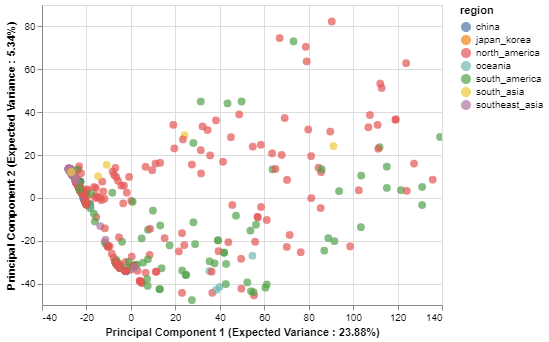

In [55]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 1', 'principal component 2',
                                    'Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                    'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                    ['strain', 'region'],'region')

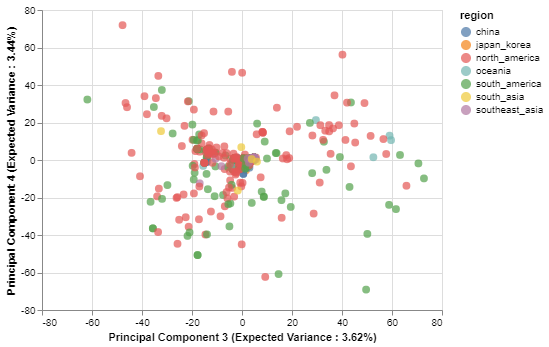

In [56]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 3', 'principal component 4',
                                    'Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                    'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")",
                                    ['strain', 'region'],'region')

# Linking the Tree with the two other PCA Plots

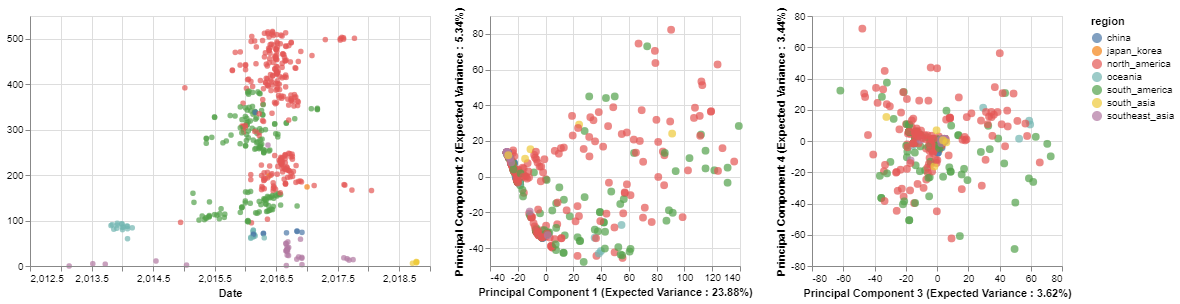

In [57]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['principal component 1','principal component 2','principal component 3','principal component 4'],
                                         ['Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                                          'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                                          'Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                                          'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                                         "region:N",['strain','region'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]


# Running PCA on the Distance Matrix
- I used sklearn.decomposition to run PCA (source code linked [here][1]
- I ran it with 10 components, and with my precomputed metric (or similarity_matrix)
- I then read it into a [Pandas DataFrame][2] for ease of use. 
[1]: https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/decomposition/pca.py#L104
[2]: https://github.com/pandas-dev/pandas/blob/v0.25.0/pandas/core/frame.py#L304-L8450

In [130]:
from sklearn.decomposition import PCA

#performing PCA on my pandas dataframe 
pca = PCA(n_components=10,svd_solver='full') #can specify n, since with no prior knowledge, I use None
principalComponents = pca.fit_transform(similarity_matrix)
principalDf = pd.DataFrame(data = principalComponents, columns = ["principal component " + str(i) for i in range(1,11)])

In [131]:
principalDf.head()

principal component 1  principal component 2  principal component 3  \
0            -149.266117             141.271180             232.168432   
1            -181.210494             123.065436             223.655927   
2             -91.117696             154.173783             231.767323   
3            -112.916854             160.376105             239.284416   
4             -29.175747             184.439204             235.913699   

   principal component 4  principal component 5  principal component 6  \
0             -56.946880             -29.019579               8.972298   
1             -50.548695             -27.427517               6.625854   
2             -57.702244             -33.790820               5.204061   
3             -60.439406             -30.258784               6.379793   
4             -49.545655             -21.389239              -1.694885   

   principal component 7  principal component 8  principal component 9  \
0               7.011067               5.233502             -15.290198   
1               7.549977               4.123703             -14.774765   
2               9.609953               4.458384             -14.947945   
3              10.604413               9.188806             -13.696823   
4               9.422272              20.831208              15.286669   

   principal component 10  
0               -3.476272  
1               -4.167120  
2                4.025742  
3               -4.407198  
4                9.158867

## Taking the result strains from reading in the metadata and concatenating it to the principal components (where each row is joined with one genome)

## Note: 
- Methods like the one below will be reused -- when one is called there will be a link back to where the code is defined/ to a methods section at the bottom.

In [132]:
finalDf = concatenate_results_with_strain_data(principalDf,result_strains,['region','strain','country'])

In [133]:
finalDf.shape

(519, 13)

### Explained Variance: 
- It tells you for each principal component, how much variance in the data is it accounting for? Usually you'd like to see that the first two principal components account for ~ 80% of the variance.

In [134]:
df = pd.concat([pd.DataFrame(np.arange(1,11)), pd.DataFrame([round(pca.explained_variance_ratio_[i],4) for i in range(0,len(pca.explained_variance_ratio_))])], axis = 1)
df.columns = ['principal components','explained variance']
df

principal components  explained variance
0                     1              0.7536
1                     2              0.1290
2                     3              0.0511
3                     4              0.0185
4                     5              0.0121
5                     6              0.0088
6                     7              0.0057
7                     8              0.0039
8                     9              0.0024
9                    10              0.0019

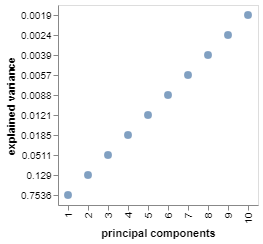

In [135]:
import altair as alt 

alt.Chart(df).mark_circle(size=60).encode(
    x='principal components:N',
    y='explained variance:N')

In [136]:
pca.explained_variance_

array([213659.87501795,  36582.8769128 ,  14489.80037182,   5243.46709973,
         3441.20533304,   2501.79107577,   1602.92365402,   1107.51172852,
          669.17672812,    549.63343959])

# Visualizing PCA in Altair
- Visualzing both PC1 (x) and PC2(y), and PC3(x) and PC4(y) in seperate plots

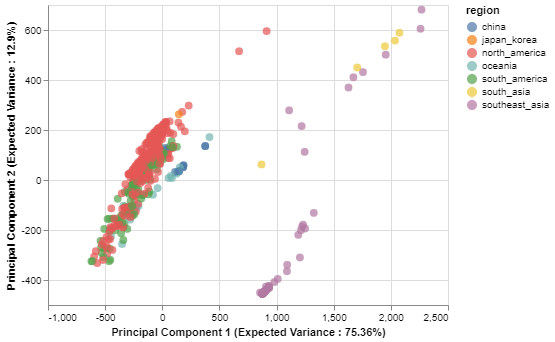

In [64]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 1','principal component 2','Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
    'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")", ['strain', 'region'],'region') 

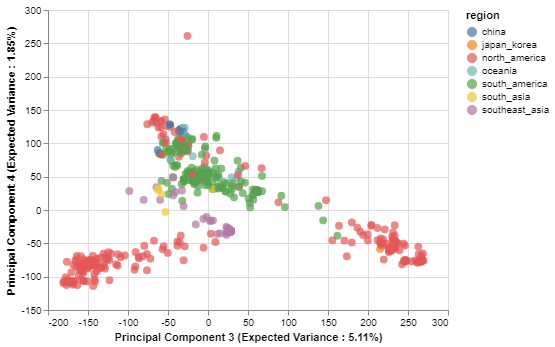

In [65]:
scatterplot_with_tooltip_interactive(finalDf,'principal component 3','principal component 4','Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
    'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")", ['strain', 'region'],'region') 

# Linking the Phylogenetic Tree with the two PCA plots
- This way we can see if the clustering we're noticing in the PCA plots are clusters reminicent of the Phylogenetic tree
- Merged the finalDf (the strain data from the alignment file) with node_df ( the strain data from the tree json) to get a dataframe that has both tree data and alignment data

In [66]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [67]:
merged_df.head()

principal component 1  principal component 2  principal component 3  \
0            -149.266117             141.271180             232.168432   
1            -181.210494             123.065436             223.655927   
2             -91.117696             154.173783             231.767323   
3            -112.916854             160.376105             239.284416   
4             -29.175747             184.439204             235.913699   

   principal component 4  principal component 5  principal component 6  \
0             -56.946880             -29.019579               8.972298   
1             -50.548695             -27.427517               6.625854   
2             -57.702244             -33.790820               5.204061   
3             -60.439406             -30.258784               6.379793   
4             -49.545655             -21.389239              -1.694885   

   principal component 7  principal component 8  principal component 9  \
0               7.011067               5.233502             -15.290198   
1               7.549977               4.123703             -14.774765   
2               9.609953               4.458384             -14.947945   
3              10.604413               9.188806             -13.696823   
4               9.422272              20.831208              15.286669   

   principal component 10         region                 strain  \
0               -3.476272  north_america  DOM/2016/MA_WGS16_024   
1               -4.167120  north_america       DOM/2016/BB_0180   
2                4.025742  north_america       DOM/2016/BB_0115   
3               -4.407198  north_america       DOM/2016/BB_0208   
4                9.158867  north_america  DOM/2016/MA_WGS16_007   

            country_x           country_y         date  parent_date  parent_y  \
0  dominican_republic  dominican_republic  2016.517454  2016.177960     202.0   
1  dominican_republic  dominican_republic  2016.298426  2015.782991     188.0   
2  dominican_republic  dominican_republic  2016.279261  2015.738263     171.5   
3  dominican_republic  dominican_republic  2016.303901  2016.145963     205.0   
4  dominican_republic  dominican_republic  2016.358658  2016.145963     205.0   

     y  
0  202  
1  188  
2  172  
3  205  
4  206

# Linking the Tree with the two other PCA Plots

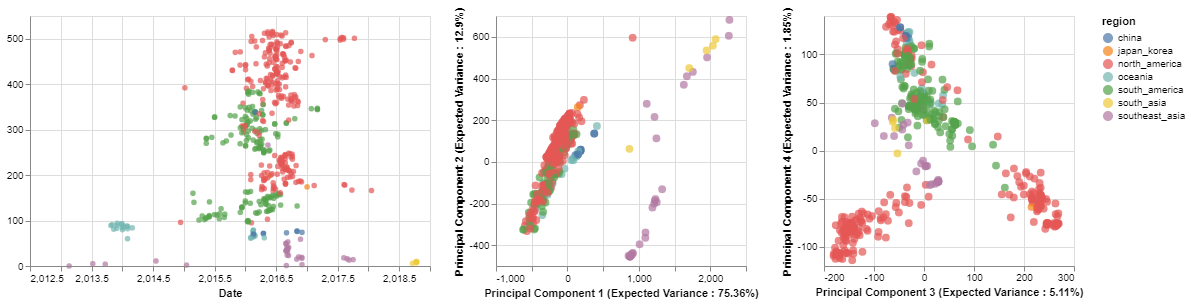

In [68]:
list_of_charts = linking_tree_with_plots_brush(merged_df,['principal component 1','principal component 2','principal component 3','principal component 4'],
                              ['Principal Component 1 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[0]*100,2)) + ")",
                               'Principal Component 2 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[1]*100,2)) + ")",
                               'Principal Component 3 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[2]*100,2)) + ")",
                               'Principal Component 4 (Expected Variance : {}%'.format(round(pca.explained_variance_ratio_[3]*100,2)) + ")"],
                              'region:N', ['strain:N', 'region:N'])
list_of_charts[0]|list_of_charts[1]|list_of_charts[2]

# Running MDS on the Dataset

In [69]:
from sklearn.manifold import MDS
embedding = MDS(n_components=10,metric=True,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(similarity_matrix)

In [70]:
raw_stress = embedding.stress_
normalized_stress = np.sqrt(raw_stress /((similarity_matrix.values.ravel() ** 2).sum() / 2))
print(normalized_stress.round(2))

0.12


In [71]:
MDS_df = pd.DataFrame(X_transformed,columns=['cluster ' + str(i) for i in range(1,11)])
print(MDS_df.head())

   cluster 1  cluster 2  cluster 3  cluster 4  cluster 5  cluster 6  \
0  -0.277185  -4.865219  17.152304 -15.823943  -1.363725  14.459628   
1   2.180477  -6.498626  14.918445 -14.762608  -2.492820  14.113363   
2   5.625084  -4.624312  21.350301 -15.096647  -5.015292  16.326330   
3   4.449630  -8.113730  16.591448 -19.654156  -1.369733  11.962549   
4   6.147506 -13.764666  15.855017 -21.983218  -6.840145  11.112579   

   cluster 7  cluster 8  cluster 9  cluster 10  
0   8.686223   7.355141   9.087703    1.978447  
1   8.313958   4.637878   8.276200    0.699802  
2   7.161048   4.880223   8.485908   -4.263891  
3  12.583215   5.786556   8.361565   -1.965405  
4  13.631444   8.613470   9.679338   -5.162369  


In [72]:
finalDf = concatenate_results_with_strain_data(MDS_df, result_strains, ['strain','region','country'])

In [73]:
finalDf.shape

(519, 13)

In [74]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [75]:
merged_df.shape

(486, 18)

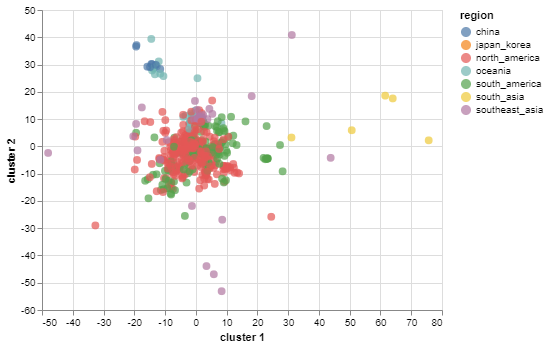

In [76]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

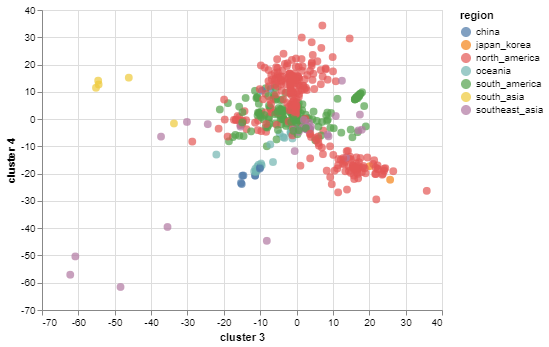

In [77]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 3','cluster 4',"cluster 3","cluster 4",['strain','region'],'region')

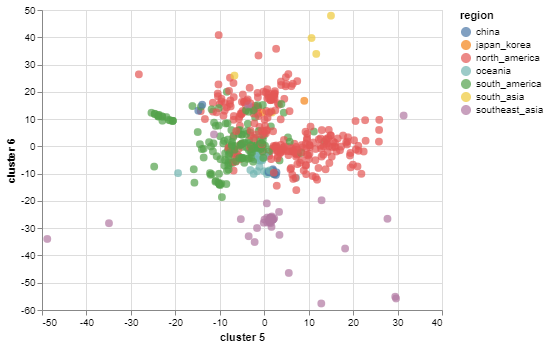

In [78]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 5','cluster 6',"cluster 5","cluster 6",['strain','region'],'region')

# Linking Tree to MDS plot

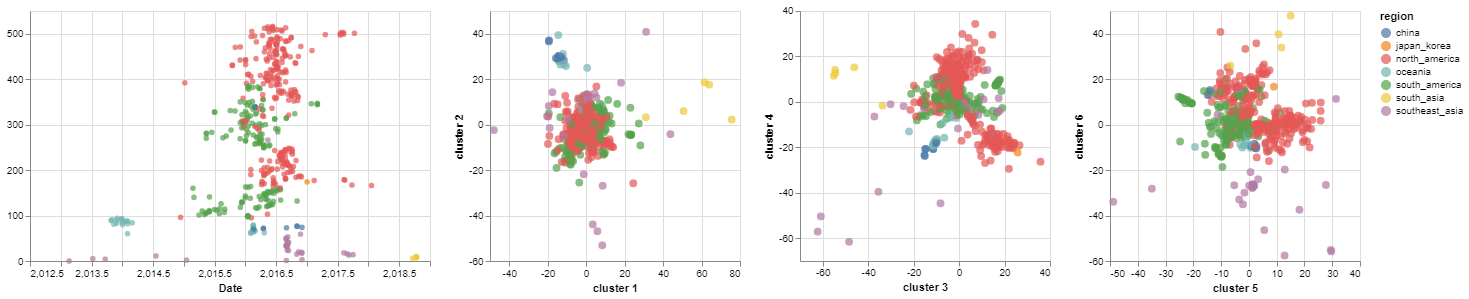

In [79]:
list_of_data_and_titles = ['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

# Running T-SNE on the Dataset 

In [80]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2,metric='precomputed',perplexity = 25.95)
X_transformed = embedding.fit_transform(similarity_matrix)

In [81]:
TSNE_df = pd.DataFrame(X_transformed,columns=['cluster ' + str(i) for i in range(1,3)])
print(TSNE_df.head())

   cluster 1  cluster 2
0  -8.286314  17.348289
1  -7.480272  18.279861
2  -8.400549  18.583746
3 -10.179845  17.103544
4 -10.590798  16.978159


In [82]:
finalDf = concatenate_results_with_strain_data(TSNE_df,result_strains,['strain','region'])

In [83]:
finalDf.shape

(519, 4)

In [84]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [85]:
merged_df.shape

(486, 9)

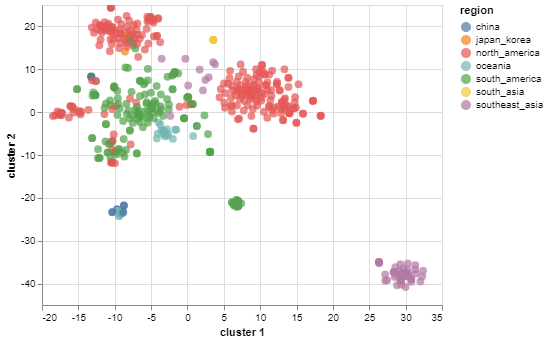

In [86]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

# Linking Tree to T-SNE plot

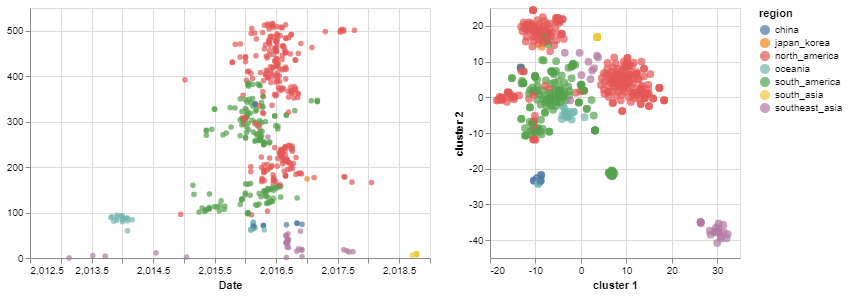

In [87]:
list_of_chart = linking_tree_with_plots_brush(merged_df,['cluster 1','cluster 2'],['cluster 1','cluster 2'],'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]

# Running UMAP on the Dataset

In [88]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(similarity_matrix)

C:\Users\srava\Miniconda3\lib\site-packages\umap\umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "..\..\..\Miniconda3\lib\site-packages\umap\umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
C:\Users\srava\Miniconda3\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "..\..\..\Miniconda3\lib\site-packages\umap\umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
C:\Users\srava\Miniconda3\lib\site-packages\numba\compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the obj

In [89]:
UMAP_df = pd.DataFrame(embedding,columns=['cluster ' + str(i) for i in range(1,3)])
print(UMAP_df.head())

   cluster 1  cluster 2
0   9.079834 -13.043282
1   9.019652 -13.198760
2   9.164019 -12.657447
3   9.041790 -12.806108
4   8.984721 -11.830906


In [90]:
finalDf = concatenate_results_with_strain_data(UMAP_df, result_strains, ['strain','region','country'])

In [91]:
finalDf.shape

(519, 5)

In [92]:
merged_df = pd.merge(finalDf,node_df,on=["strain","region"]).dropna()

In [93]:
merged_df.shape

(486, 10)

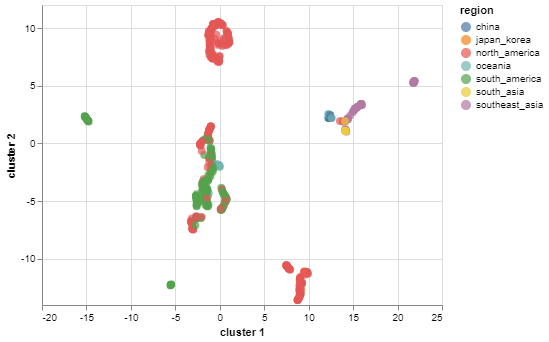

In [94]:
scatterplot_with_tooltip_interactive(finalDf,'cluster 1','cluster 2',"cluster 1","cluster 2",['strain','region'],'region')

# Linking Tree with UMAP plot

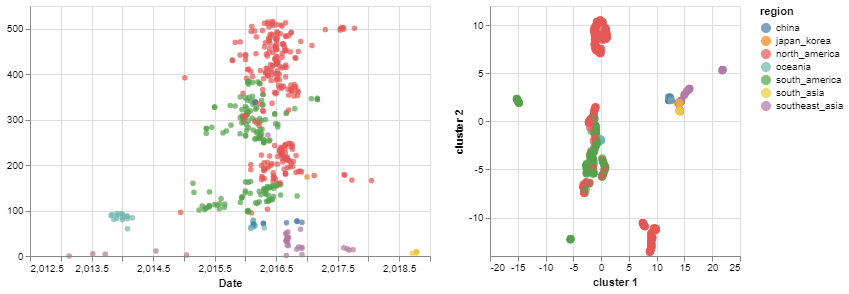

In [95]:
list_of_data_and_titles = ['cluster 1','cluster 2']
list_of_chart = linking_tree_with_plots_brush(merged_df,list_of_data_and_titles,list_of_data_and_titles,'region:N',["region:N","strain:N"])
list_of_chart[0]|list_of_chart[1]

# Notes to Self:

- Fix/Add pairwise plot to graphs
- Collapse cells underneath Markdown headers
- Get docstrings above methods to show up when user presses SHIFT + TAB
- link back to the methods section for user each time method is used